In [1]:
!pip install --q --user cmdstanpy
!pip install --q --upgrade prophet

In [2]:
import pandas as pd
import numpy as np
import prophet
from prophet import Prophet
from datetime import date, timedelta

# Generate dummy historical data

# Define a 2-year period of weekly data (104 weeks)
start_date = date(2023, 1, 1)
end_date = start_date + timedelta(weeks=104)
date_range = pd.date_range(start=start_date, end=end_date, freq='W-SUN')

# Create the Historical DataFrame (occupancy_df)
df = pd.DataFrame({'date': date_range})

df.head()


,date
0,2023-01-01
1,2023-01-08
2,2023-01-15
3,2023-01-22
4,2023-01-29


In [3]:
#prophet.__version__

In [4]:
# Target Variable (y): Weekly Occupancy Rate (simulating yearly seasonality)
# Base occupancy around 90%, with some yearly dips/peaks
base_occupancy = 0.90
# Add a yearly sine wave for seasonality
df['occupancy_rate'] = (base_occupancy
                        + 0.03 * np.sin(2 * np.pi * df.index.values / 52) # 52 weeks in a year
                        + np.random.normal(0, 0.01, len(df)) # Add noise
                       )
df['occupancy_rate'] = df['occupancy_rate'].clip(0.85, 0.98) # Keep it within a realistic range
df.head()


,date,occupancy_rate
0,2023-01-01,0.919262
1,2023-01-08,0.915649
2,2023-01-15,0.897707
3,2023-01-22,0.925106
4,2023-01-29,0.904479


In [5]:
# External Features (Regressors)
# 1. leases_expiring_30: Tends to rise/fall with seasonality
df['leases_expiring_30'] = np.round(100 + 30 * np.sin(2 * np.pi * df.index.values / 52) + np.random.normal(0, 10, len(df)))
df['leases_expiring_30'] = df['leases_expiring_30'].clip(50, 150)

# 2. avg_renewal_prob: Tends to be inversely related to expiring leases
df['avg_renewal_prob'] = 0.65 - 0.05 * np.sin(2 * np.pi * df.index.values / 52) + np.random.normal(0, 0.02, len(df))
df['avg_renewal_prob'] = df['avg_renewal_prob'].clip(0.55, 0.75)

# 3. market_vacancy_rate: Simulating a slight upward trend over 2 years
df['market_vacancy_rate'] = 0.04 + 0.0005 * df.index.values + np.random.normal(0, 0.005, len(df))
df['market_vacancy_rate'] = df['market_vacancy_rate'].clip(0.03, 0.06)

# Rename columns for Prophet
df = df.rename(columns={'date':'ds', 'occupancy_rate':'y'})
df.head()

,ds,y,leases_expiring_30,avg_renewal_prob,market_vacancy_rate
0,2023-01-01,0.919262,108.0,0.634686,0.043566
1,2023-01-08,0.915649,103.0,0.631291,0.040988
2,2023-01-15,0.897707,105.0,0.626085,0.044048
3,2023-01-22,0.925106,109.0,0.608384,0.042277
4,2023-01-29,0.904479,117.0,0.652990,0.041545


In [6]:
# Model set up

#from cmdstanpy import CmdStanLogger, CmdStanArgs, CmdStanModel

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True, # Weekly seasonality in weekly data is often not useful, but included for completeness
    seasonality_mode="additive",
    stan_backend=None
)

# Add the external regressors (MUST use the exact column names present in df)
for reg in ["leases_expiring_30", "avg_renewal_prob", "market_vacancy_rate"]:
    model.add_regressor(reg)

# FIT the model on the historical data (df). This learns the influence (coefficients)
print("Fitting Model (Learning Coefficients)")
model.fit(df)
print("Model fitting complete.")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting Model (Learning Coefficients)
Model fitting complete.


In [7]:
# FORECASTING (APPLYING)

# A. Create the future dates (90 days = 13 full weeks at 'W' frequency)
future = model.make_future_dataframe(periods=13, freq='W-SUN') # Generates future 'ds' dates

# B. Create DUMMY FUTURE VALUES for the Regressors
# You must supply these values based on projections/assumptions.
future_features = pd.DataFrame({
    'ds': future[future['ds'] > df['ds'].max()]['ds'],
    # Assuming leases expiring will be high next 13 weeks
    'leases_expiring_30': np.clip(np.random.normal(loc=120, scale=10, size=13), 100, 140),
    # Assuming average renewal probability remains high
    'avg_renewal_prob': np.clip(np.random.normal(loc=0.70, scale=0.01, size=13), 0.65, 0.75),
    # Assuming market vacancy continues its slight rise
    'market_vacancy_rate': np.clip(np.random.normal(loc=0.055, scale=0.002, size=13), 0.05, 0.06),
})

# C. Merge the original historical data's regressors into the future dataframe
# This ensures regressors are present for the historical period
for reg in ["leases_expiring_30", "avg_renewal_prob", "market_vacancy_rate"]:
    future[reg] = df[reg]

# D. MERGE the projected features into the future dataframe
# This is the line that makes forecasting possible with regressors!
future.update(future_features)


# E. PREDICT the occupancy rate
print("--- Generating 13-Week Forecast ---")
forecast = model.predict(future)

# --- 4. OUTPUT RESULTS ---

# print("\n--- Model Coefficients (Learned from df) ---")
# # Extract the learned coefficients for the regressors from model.params['beta']
# beta_params = model.params['beta']

# # Identify the columns corresponding to the extra regressors
# regressor_cols = [col for col in beta_params.columns if col.startswith('extra_regressors_additive_')]

# # Calculate the mean of the beta coefficients for each regressor
# reg_coeffs_mean = beta_params[regressor_cols].mean(axis=0)

# # Extract the original regressor names
# reg_names = [reg.replace('extra_regressors_additive_', '') for reg in regressor_cols]

# # Create a pandas Series from the mean coefficients with regressor names as index
# reg_coeffs_series = pd.Series(reg_coeffs_mean.values, index=reg_names)

# # Convert the Series to a DataFrame and transpose it for the desired output format
# reg_coeffs_df = pd.DataFrame(reg_coeffs_series, columns=['Coefficient']).T
# print(reg_coeffs_df)


print("\n--- Final 5 Weeks of Forecast (yhat is the prediction) ---")
# Show the last 5 rows of the forecast (the prediction period)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5).to_markdown(index=False))

# Plotting the forecast can be done with:
# fig = model.plot(forecast)
# plt.show()

--- Generating 13-Week Forecast ---

--- Final 5 Weeks of Forecast (yhat is the prediction) ---
| ds                  |     yhat |   yhat_lower |   yhat_upper |
|:--------------------|---------:|-------------:|-------------:|
| 2025-03-02 00:00:00 | 0.919447 |     0.908536 |     0.930636 |
| 2025-03-09 00:00:00 | 0.925928 |     0.915065 |     0.936395 |
| 2025-03-16 00:00:00 | 0.927407 |     0.916552 |     0.938382 |
| 2025-03-23 00:00:00 | 0.925201 |     0.913899 |     0.93589  |
| 2025-03-30 00:00:00 | 0.918514 |     0.907826 |     0.928932 |


In [8]:
# --- Coefficients of extra regressors (version-robust approach) ---

regressor_names_added = ["leases_expiring_30", "avg_renewal_prob", "market_vacancy_rate"]

# 1) Make sure `forecast` contains both history and future. If your `future` includes
#    all past rows (via make_future_dataframe), you're good. Otherwise, predict on history:
hist_forecast = model.predict(model.history[["ds"] + regressor_names_added])

# 2) For each regressor, Prophet puts a component column named exactly as the regressor.
#    Its value equals beta * regressor_value for additive regressors.
coeffs = {}
for r in regressor_names_added:
    if r not in hist_forecast.columns:
        raise ValueError(
            f"Prophet did not produce a component column for '{r}'. "
            "Confirm you called model.add_regressor('{r}') before fit() and that its mode is additive."
        )
    # effect = beta * r_value  => beta = effect / r_value (where r_value != 0)
    r_vals = model.history[r].to_numpy()
    eff_vals = hist_forecast[r].to_numpy()

    # avoid divide-by-zero / NaNs
    mask = np.isfinite(r_vals) & np.isfinite(eff_vals) & (np.abs(r_vals) > 1e-12)
    if mask.sum() == 0:
        coeffs[r] = np.nan
        continue

    beta_estimates = eff_vals[mask] / r_vals[mask]
    # robust central tendency (median resists outliers)
    coeffs[r] = float(np.median(beta_estimates))

reg_coeffs_df = pd.DataFrame([coeffs], index=["Coefficient"])
print("\n--- Model Coefficients (estimated from components) ---")
print(reg_coeffs_df)


--- Model Coefficients (estimated from components) ---
             leases_expiring_30  avg_renewal_prob  market_vacancy_rate
Coefficient           -0.006027         -0.000608            -0.376797


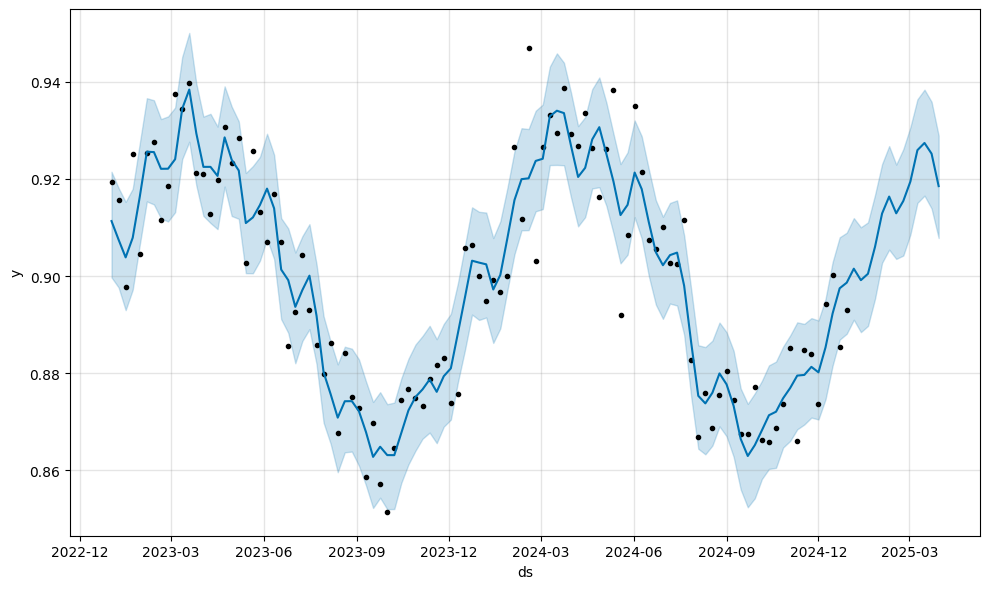

In [9]:
import matplotlib.pyplot as plt

# Plotting the forecast can be done with:
fig = model.plot(forecast)
plt.show()